# Predicting sport specific performance from field testing in synchronized swimming
Romain Martinez ([GitHub](https://github.com/romainmartinez))

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import altair as alt

In [2]:
NORMALIZE = 'False'

## Get the data

In [3]:
DATA_PATH = Path("./data/zTable.xlsx")
df = pd.read_excel(DATA_PATH)

df.head()

,Name,Height,Weight,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,...,FLEX/D,EB max force,EB mean force,EB sd force,EB max height,EB min height,EB mean height,EB sd height,EB max-min height,BB
0,'aissatou_sougou',1.69,48.52,287.05,285.00,206.85,179.90,92.85,94.95,52.3,...,146.00,8.33,6.770000,0.439447,8.5,7.5,8.083333,0.376386,1.0,9.5
1,'anais_charland',1.63,62.13,292.75,302.75,239.85,207.85,109.25,103.25,98.4,...,123.35,9.43,7.762753,0.584721,7.5,7.0,7.083333,0.204124,0.5,8.5
2,'anne sophie_moreau',1.71,54.90,252.40,258.55,233.45,233.65,69.30,68.80,120.0,...,204.80,8.76,6.725683,0.767079,8.0,7.5,7.833333,0.258199,0.5,8.5
3,'audrey_lamothe',1.50,43.44,213.45,227.40,174.00,132.10,54.20,56.40,39.9,...,112.25,9.86,7.315823,0.815853,8.0,7.0,7.416667,0.376386,1.0,8.5
4,'billie_francis',1.78,62.04,281.75,296.20,258.65,227.25,97.25,99.05,77.2,...,152.85,10.77,8.995158,0.570680,7.5,7.0,7.333333,0.258199,0.5,9.0


In [4]:
# variables
variables = [
    "ADD/G",
    "ADD/D",
    "ABD/G",
    "ABD/D",
    "ER/G",
    "ER/D",
    "IR/G",
    "IR/D",
    "EXT/G",
    "EXT/D",
    "FLEX/G",
    "FLEX/D",
]
X = df[variables] / 9.81
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
3,21.758410,23.180428,17.737003,13.465851,5.524975,5.749235,4.067278,3.792049,14.123344,0.203874,12.003058,11.442406
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040


In [5]:
# target
targets = ["BB", "EB mean height", "EB mean force"]
y = df[targets].rename(
    columns={"BB": "BB-H", "EB mean height": "EB-H", "EB mean force": "EB-F"}
)
y.head()

,BB-H,EB-H,EB-F
0,9.5,8.083333,6.770000
1,8.5,7.083333,7.762753
2,8.5,7.833333,6.725683
3,8.5,7.416667,7.315823
4,9.0,7.333333,8.995158


## Normalize data
We should normalize the field tests (`X`) by anthropometric measurements.

In [6]:
if NORMALIZE == "weight":
    normalizer = df["Weight"]
elif NORMALIZE == "IMC":
    normalizer = df["Weight"] / df["Height"] ** 2
elif NORMALIZE == "weight-height":
    normalizer = df["Weight"] * df["Height"]
else:
    normalizer = 1
    print("data not normalized")
X = X.divide(normalizer, axis=0)

data not normalized


## NaN remover

In [7]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "32.95107033639144"
participant no.: 41
	test: IR/G
		"nan" replace by "12.125382262996942"
participant no.: 90
	test: IR/G
		"nan" replace by "9.403669724770642"


## Data description

In [8]:
def hboxplot(data, x, y, color=None):
    """Horizontal box plot in Atlair"""
    alt_color = alt.value("grey") if not color else alt.Color(color, legend=None)

    base = alt.Chart(data).encode(alt.Y(y, title=None), color=alt_color)

    lower_plot = base.mark_rule().encode(
        alt.X(f"min({x})", scale=alt.Scale(zero=False), title=None), alt.X2(f"q1({x})")
    )
    middle_plot = base.mark_bar().encode(alt.X(f"q1({x})"), alt.X2(f"q3({x})"))
    upper_plot = base.mark_rule().encode(alt.X(f"q3({x})"), alt.X2(f"max({x})"))

    middle_tick = base.mark_tick(size=17).encode(
        alt.X(f"median({x})"), color=alt.value("black")
    )
    return lower_plot + middle_plot + upper_plot + middle_tick

In [9]:
def plot_bars(data, x=alt.X(), y=None, color=alt.Color(), column=None, row=None):
    base = alt.Chart().encode(x=x)
    bar = base.mark_bar(color="grey").encode(
        alt.Y(f"mean({y})", title=None), color=color
    )
    ci = base.mark_rule().encode(alt.Y(f"ci0({y})"), alt.Y2(f"ci1({y})"))
    if column:
        return (bar + ci).facet(data=data, column=column)
    elif column and row:
        return (bar + ci).facet(data=data, column=column, row=row)
    else:
        return (bar + ci).facet(data=data)

### Variables $X$
Hip strength tests (field testing):
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test

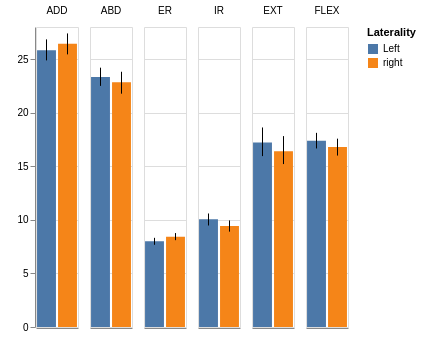

In [10]:
bar_data = X.melt().assign(
    test=lambda x: x["variable"].str.split("/").str[0],
    Laterality=lambda x: x["variable"]
    .str.split("/")
    .str[1]
    .replace({"D": "right", "G": "Left"}),
)

sort_tests = alt.Sort(["ADD", "ABD", "ER", "IR", "EXT", "FLEX"])

plot_bars(
    data=bar_data,
    x=alt.X("Laterality", title=None),
    y="value",
    color="Laterality",
    column=alt.Column("test", title=None, sort=sort_tests),
).configure_axisX(labels=False, ticks=False)

### Targets $y$

An empirical cumulative distribution function, or ECDF, is a convenient way to visualize a univariate probability distribution. Consider a measurement x in a set of measurements X. The ECDF evaluated at x is defined as

ECDF(x) = fraction of data points in X that are ≤ x.

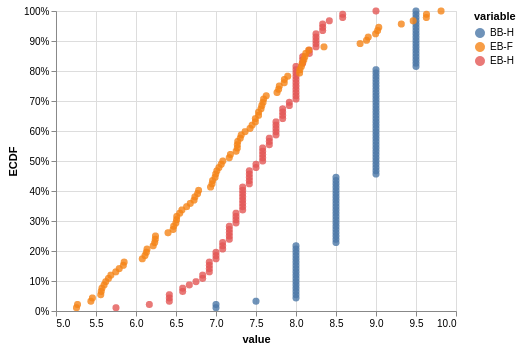

In [26]:
y_melted = y.melt()
y_melted["ECDF"] = y_melted.groupby("variable")["value"].transform(
    lambda x: x.rank(method="first") / len(x)
)

alt.Chart(y_melted).mark_circle(size=50, opacity=0.8).encode(
    alt.X("value", scale=alt.Scale(zero=False)),
    alt.Y("ECDF", axis=alt.Axis(format="%")),
    alt.Color("variable"),
    alt.Tooltip(["ECDF:Q", "value:Q"]),
)

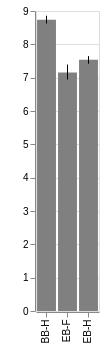

In [12]:
plot_bars(data=y.melt(), x=alt.X("variable", title=None), y="value")

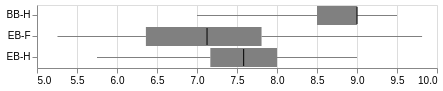

In [13]:
hboxplot(y.melt(), x='value', y='variable')

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [14]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance

In [15]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [16]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

In [17]:
imb_cols = X_augmented.columns.str.startswith("imb")
imb = X_augmented.iloc[:, imb_cols].melt(value_name="Imbalance (%)", var_name="Test")
force = X_augmented.iloc[:, ~imb_cols].melt(value_name="Force (kg)", var_name="Test")
X_augmented_melted = force.join(imb["Imbalance (%)"]).melt(id_vars="Test", var_name='Variable')
X_augmented_melted.head()

,Test,Variable,value
0,ADD,Force (kg),29.156099
1,ADD,Force (kg),30.343123
2,ADD,Force (kg),26.038531
3,ADD,Force (kg),22.446920
4,ADD,Force (kg),29.438773


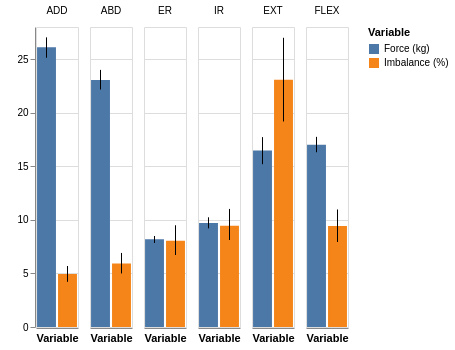

In [18]:
plot_bars(
    X_augmented_melted,
    x="Variable",
    y="value",
    color="Variable",
    column=alt.Column("Test", title=None, sort=sort_tests),
).configure_axisX(labels=False, ticks=False)

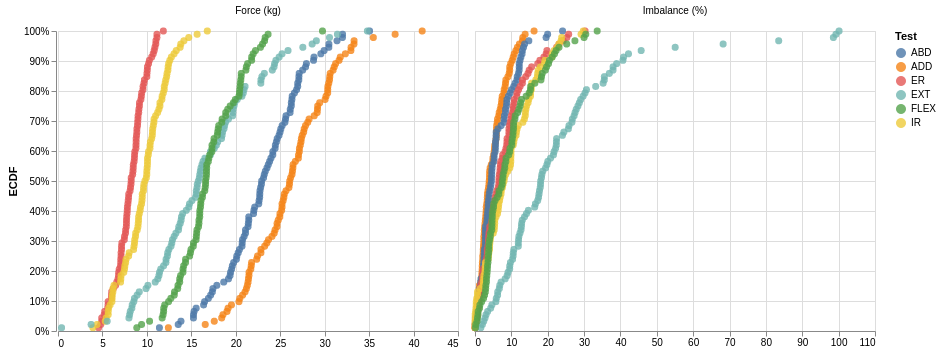

In [27]:
t = X_augmented_melted.copy()
t["ECDF"] = t.groupby(["Variable", "Test"])["value"].transform(
    lambda x: x.rank(method="first") / len(x)
)

alt.Chart(t).mark_circle(size=50, opacity=0.8).encode(
    alt.X("value", scale=alt.Scale(zero=False), title=None),
    alt.Y("ECDF", axis=alt.Axis(format="%")),
    alt.Color("Test"),
    alt.Tooltip(["Test:N", "ECDF:Q", "value:Q"]),
).facet(column=alt.Column("Variable", title=None)).resolve_scale(x="independent")